## Read video tape with OpenCV2

In [1]:
import cv2
from os.path import join
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
VIDEO_FOLDER = 'data/CDF M17 VBALL - Voiron/'
VIDEO_NAME = 'Vb@ll - Voiron 1er Set 25-21.mkv'

src = join(VIDEO_FOLDER, VIDEO_NAME)
cap = cv2.VideoCapture(src)

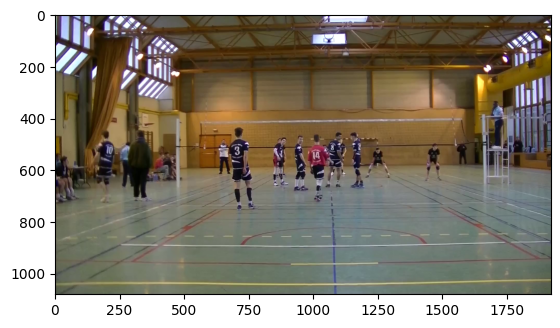

True


In [3]:
ret, frame = cap.read()
rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.show()
print(ret)

In [18]:
def read_video(src, limit_output_size=10, offset_between=0):
    """Read the video stored at path 'src' using cv2, return the list of the frames of the video.
    
    Each read frame is transformed to rgb format.
    <param limit_output_size> int : maximum number of frames to be returned
    <param offset_between> int : number of unselected frames between two selected frames
    """
    video_cap = cv2.VideoCapture(src)
    frames = []
    iter = 0
    offset = offset_between
    progress = tqdm(total=limit_output_size*offset_between)
    while video_cap.isOpened() and iter < limit_output_size:
        try:
            ret, frame = video_cap.read()
            if offset == 0:
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(rgb)
                iter += 1
                offset = offset_between
            else:
                offset -= 1
            progress.update(1)
        except ValueError as err:
            print('Frame loading failed : ', err)
            break
    print('Full output computed')
    return frames


#frames = read_video(src, limit_output_size=100, offset_between=10)
    

In [1]:
from video_processor import VideoProcessor

In [2]:
import os
VIDEO_FOLDER = 'data/CDF M17 VBALL - Voiron/'
VIDEO_NAME = 'Vb@ll - Voiron 1er Set 25-21.mkv'

src = os.path.join(VIDEO_FOLDER, VIDEO_NAME)

In [3]:
vid = VideoProcessor(src,limit_output_size=10)


Processing: 100%|██████████

Frames processing completed


C:\Users\romai\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\_api\__init__.py:127: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if val not in values:


ValueError: array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 64,  47,  53],
        [ 62,  45,  51],
        [ 61,  44,  50]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 62,  45,  51],
        [ 58,  41,  47],
        [ 56,  39,  45]],

       [[255, 255, 255],
        [255, 255, 255],
        [246, 254, 242],
        ...,
        [ 58,  41,  47],
        [ 50,  33,  39],
        [ 47,  30,  36]],

       ...,

       [[ 83,  89,  80],
        [ 83,  89,  80],
        [ 83,  89,  80],
        ...,
        [ 82,  89,  73],
        [ 81,  88,  72],
        [ 83,  90,  74]],

       [[ 83,  89,  80],
        [ 83,  89,  80],
        [ 83,  89,  80],
        ...,
        [ 73,  77,  62],
        [ 73,  77,  62],
        [ 81,  85,  70]],

       [[ 83,  89,  80],
        [ 83,  89,  80],
        [ 83,  89,  80],
        ...,
        [ 67,  71,  56],
        [ 67,  71,  56],
        [ 81,  85,  70]]], dtype=uint8) is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

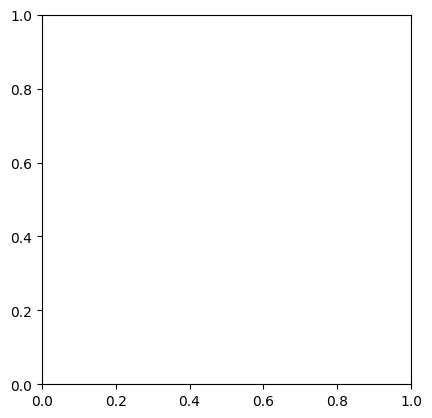

In [4]:
vid.show_video()